# Evaluate

In this notebook we evaluate the accuracy of the predicted alignments.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import os.path
import pandas as pd
import pickle

In [3]:
ANNOTATIONS_ROOT = Path('Chopin_Mazurkas/annotations_beat')
query_list = Path('cfg_files/query.train.list')

### Evaluate hypothesis directory

First evaluate a single hypothesis directory.

In [4]:
def eval_dir(hypdir, querylist, hop_sec, savefile = None):
    
    allErrs = {}
    cnt = 0
    print(f'Processing {hypdir} ', end='')
    with open(querylist, 'r') as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            basename = os.path.basename(parts[0]) + '__' + os.path.basename(parts[1])
            hypfile = hypdir + '/' + basename + '.pkl'
            if not os.path.exists(hypfile):
                print("X", end='')
                continue
            allErrs[basename] = eval_file(hypfile, hop_sec)
            cnt += 1
            if cnt % 500 == 0:
                print(".", end='')
    print(' done')
    if savefile:
        pickle.dump(allErrs, open(savefile, 'wb'))
        
    return allErrs

In [5]:
def eval_file(hypfile, hop_sec):
    parts = os.path.basename(hypfile).split('__')
    assert len(parts) == 2
    piece = extractPieceName(parts[0])
    annotfile1 = (ANNOTATIONS_ROOT / piece / parts[0]).with_suffix('.beat')
    annotfile2 = (ANNOTATIONS_ROOT / piece / parts[1]).with_suffix('.beat')
    gt1 = getTimestamps(annotfile1)
    gt2 = getTimestamps(annotfile2)
    hypalign = loadAlignment(hypfile) # warping path in frames
    if hypalign is None:
        err = [] # no valid path
    else:
        pred2 = np.interp(gt1, hypalign[0,:]*hop_sec, hypalign[1,:]*hop_sec)
        err = pred2 - gt2
    return err

In [6]:
def extractPieceName(fullpath):
    basename = os.path.basename(fullpath) # e.g. Chopin_Op068No3_Sztompka-1959_pid9170b-21
    parts = basename.split('_')
    piece = '_'.join(parts[0:2]) # e.g. Chopin_Op068No3
    return piece

In [7]:
def getTimestamps(annotfile):
    df = pd.read_csv(annotfile, header=None, sep='\s+', skiprows=3)
    return np.array(df[0])

In [8]:
def loadAlignment(hypfile):
    with open(hypfile, 'rb') as f:
        d = pickle.load(f)
    return d

Evaluate a single hypothesis directory.

In [11]:
hypdir = 'experiments_train/wsdtw_2_clean'
savefile = 'evaluations_train/wsdtw_2_clean.pkl'
hop_sec = 512 * 1 / 22050
allErrs = eval_dir(hypdir, query_list, hop_sec, savefile)

Processing experiments_train/wsdtw_2_clean X... done


In [19]:
hypdir = 'experiments_train/ssdtw_test3_2_clean'
savefile = 'evaluations_train/ssdtw_test3_2_clean.pkl'
hop_sec = 512 * 1 / 22050
allErrs = eval_dir(hypdir, query_list, hop_sec, savefile)

Processing experiments_train/ssdtw_test3_2_clean XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX.. done


Evaluate all hypothesis directories.

In [29]:
def eval_all_dirs(rootdir, querylist, hop_sec, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    for hypdir in glob.glob(f'{rootdir}/ssdtw_test5_*'):
        savefile = outdir + '/' + os.path.basename(hypdir) + '.pkl'
        allErrs = eval_dir(hypdir, querylist, hop_sec, savefile = savefile)

In [30]:
EXPERIMENTS_ROOT = 'experiments_train'
hop_sec = 512 * 1 / 22050
outdir = 'evaluations_train'
eval_all_dirs(EXPERIMENTS_ROOT, query_list, hop_sec, outdir)

Processing experiments_train/ssdtw_test5_2_clean X... done
Processing experiments_train/ssdtw_test5_4_clean X... done
Processing experiments_train/ssdtw_test5_8_clean X... done
Processing experiments_train/ssdtw_test5_16_clean X... done
Processing experiments_train/ssdtw_test5_32_clean X... done


### Plot error vs tolerance

In [13]:
def calc_error_rates(errFile, maxTol):
    
    # read from file
    with open(errFile, 'rb') as f:
        allErrs = pickle.load(f)
    
    # collect all errors
    errsFlat = []
    for query in allErrs:
        errs = np.array(allErrs[query])
        errsFlat.append(errs)
    errsFlat = np.concatenate(errsFlat)
    
    # calculate error rates
    errRates = np.zeros(maxTol+1)
    for i in range(maxTol+1):
        errRates[i] = np.mean(np.abs(errsFlat) > i/1000)
    
    return errRates, errsFlat

In [14]:
def calc_error_rates_batch(indir, basenames, maxTol):
    errRates = np.zeros((len(basenames), maxTol+1))
    allErrVals = []
    print('Computing error rates ', end='')
    for i, basename in enumerate(basenames):
        errFile = indir + '/' + basename + '.pkl'
        errRates[i,:], errors = calc_error_rates(errFile, maxTol)
        allErrVals.append(errors)
        print('.', end='')
    print(' done')
    return errRates, allErrVals

In [15]:
def plot_multiple_roc(errRates, basenames):
    numSystems = errRates.shape[0]
    maxTol = errRates.shape[1] - 1
    for i in range(numSystems):
        plt.plot(np.arange(maxTol+1), errRates[i,:] * 100.0)
    plt.legend(basenames, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Error Tolerance (ms)')
    plt.ylabel('Error Rate (%)')
    plt.show()
    return

In [31]:
EVAL_ROOT_DIR = 'evaluations_train'
#toPlot = ['dtw_clean', 'segmental_2_clean', 'segmental_4_clean', 'segmental_8_clean', 'segmental_16_clean', 'segmental_32_clean', 'pardtw_2_clean', 'pardtw_4_clean', 'pardtw_8_clean', 'pardtw_16_clean', 'pardtw_32_clean']

toPlot = ['dtw_clean', 'subsequence_dtw_clean', \
          'nsdtw_2_clean', 'nsdtw_4_clean', 'nsdtw_8_clean', 'nsdtw_16_clean', 'nsdtw_32_clean', \
          'wsdtw_2_clean', 'wsdtw_4_clean', 'wsdtw_8_clean', 'wsdtw_16_clean', 'wsdtw_32_clean', \
          'ssdtw_test5_2_clean', 'ssdtw_test5_4_clean', 'ssdtw_test5_8_clean', 'ssdtw_test5_16_clean', 'ssdtw_test5_32_clean']

"""
toPlot = ['ssdtw_2_clean', 'ssdtw_4_clean', 'ssdtw_8_clean', 'ssdtw_16_clean', 'ssdtw_32_clean', \
          'ssdtw_1_2_clean', 'ssdtw_1_4_clean', 'ssdtw_1_8_clean', 'ssdtw_1_16_clean', 'ssdtw_1_32_clean']
"""
#toPlot = ['ssdtw_2_clean', 'ssdtw_test4_2_clean', 'ssdtw_cython_2_clean']
maxTol = 1000 # in msec
errRates, errVals = calc_error_rates_batch(EVAL_ROOT_DIR, toPlot, maxTol)

Computing error rates ................. done


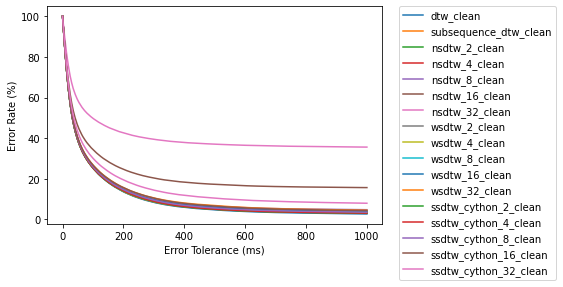

In [16]:
plot_multiple_roc(errRates, toPlot)

### Histogram of selected error rates

In [17]:
def plot_grouped_histogram1(errRates, basenames, tols):  
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate", size=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
    return

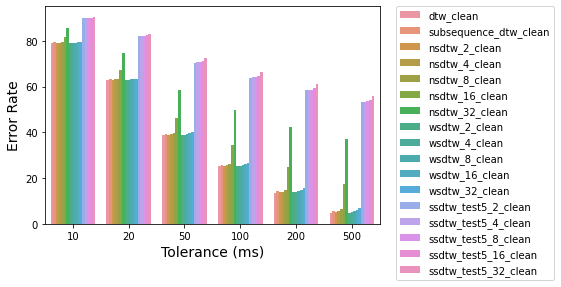

In [32]:
tols = [10, 20, 50, 100, 200, 500] # in msec
plot_grouped_histogram1(errRates, toPlot, tols)

### Final results plot for paper

This one is touched up to look nicer.

In [ ]:
def plot_grouped_histogram1(errRates_bars, errRates_dots, basenames, tols, savefile = None):  
    # Histogram grouped by tolerance
    
    # first construct DataFrame
    data = []
    for i, system in enumerate(basenames):
        for tol in tols:
            data.append((system, tol, errRates[i,tol] * 100.0))
    df = pd.DataFrame(data, columns = ['System', 'Tolerance', 'Error'])
    
    # grouped barplot (DTW & WSDTW)
    sns.barplot(x="Tolerance", y="Error", hue="System", data=df)
    plt.xlabel("Tolerance (ms)", size=14)
    plt.ylabel("Error Rate (%)", size=14)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc='upper right')
    
    # overlay dots for SSDTW results
    width_bar = .135
    x_coords = []
    y_coords = []
    for i, tol in enumerate(tols):
        for j in range(errRates_dots.shape[0]):
            x_coords.append(i+(-1.5+j)*width_bar)
            y_coords.append(errRates_dots[j,tol] * 100.0)
    plt.plot(x_coords, y_coords, 'ko', markersize=3)
    
    if savefile:
        plt.savefig(savefile, bbox_inches = 'tight')
    
    return

In [ ]:
tols = [10, 20, 50, 100, 200, 500] # in msec
display_names = ['DTW', 'SegDTW-2', 'SegDTW-4', 'SegDTW-8', 'SegDTW-16','SegDTW-32']
savefile = 'results.png'
plot_grouped_histogram1(errRates[0:6,:], errRates[6:,:], display_names, tols, savefile)

### Runtime Analysis

In [31]:
dtw_runtimes, dtw_sizes = pickle.load(open('dtw_prof.pkl', 'rb'))
subsequence_dtw_runtimes, subsequence_dtw_sizes = pickle.load(open('subsequence_dtw_prof.pkl', 'rb'))
nsdtw_runtimes, nsdtw_segments, nsdtw_sizes = pickle.load(open('nsdtw_prof.pkl', 'rb'))
wsdtw_runtimes, wsdtw_segments, wsdtw_sizes = pickle.load(open('wsdtw_prof.pkl', 'rb'))
ssdtw_runtimes, ssdtw_segments, ssdtw_sizes = pickle.load(open('ssdtw_prof.pkl', 'rb'))

Numbers for runtime table

In [32]:
dtw_avgs = np.mean(np.sum(dtw_runtimes[::-1,:,:], axis=2), axis=1)

In [33]:
subsequence_dtw_avgs = np.mean(np.sum(subsequence_dtw_runtimes[::-1,:,:], axis=2), axis=1)

In [34]:
nsdtw_avgs = np.mean(np.sum(nsdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [35]:
wsdtw_avgs = np.mean(np.sum(wsdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [36]:
ssdtw_avgs = np.mean(np.sum(ssdtw_runtimes[:,::-1,:,:], axis=3), axis=2)

In [41]:
all_avgs = np.vstack((dtw_avgs.reshape((1,-1)), \
                     subsequence_dtw_avgs.reshape((1,-1)), \
                     nsdtw_avgs, wsdtw_avgs, ssdtw_avgs))

In [42]:
# first row: DTW
# second row: subsequence DTW
# next 5 rows: NSDTW with segments = 2, 4, 8, 16, 32
# next 5 rows: WSDTW with segments = 2, 4, 8, 16, 32
# next 5 rows: SSDTW with segments = 2, 4, 8, 16, 32
all_avgs

array([[2.63556004e-02, 1.60772943e-01, 9.99313426e-01, 3.80361595e+00,
        1.54498972e+01, 1.11752989e+02],
       [2.60246515e-02, 1.66234851e-01, 1.00719569e+00, 3.81715865e+00,
        1.51009114e+01, 1.08192165e+02],
       [2.41136074e-02, 1.26886988e-01, 9.90062118e-01, 3.79513888e+00,
        1.49665424e+01, 1.08548256e+02],
       [2.44884729e-02, 1.17586732e-01, 8.69602656e-01, 3.76497159e+00,
        1.49895921e+01, 1.00267310e+02],
       [2.52540112e-02, 1.13694549e-01, 7.20169044e-01, 3.75432951e+00,
        1.49575278e+01, 1.03524786e+02],
       [2.49893904e-02, 1.07810307e-01, 6.90110826e-01, 3.33350561e+00,
        1.49338117e+01, 1.01218830e+02],
       [2.73777008e-02, 1.09722328e-01, 6.81367612e-01, 2.63830678e+00,
        1.48775133e+01, 1.01061151e+02],
       [2.59238243e-02, 1.24614382e-01, 9.69269681e-01, 3.71943834e+00,
        1.59683259e+01, 1.03614343e+02],
       [2.43222952e-02, 1.15424919e-01, 8.69526100e-01, 3.77664068e+00,
        1.52302313e+01, 

In [53]:
all_avgs.shape

(17, 6)

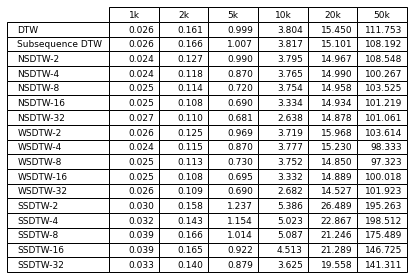

In [59]:
columns = ['1k', '2k', '5k', '10k', '20k', '50k']
rows = ['DTW', 'Subsequence DTW']
segment_algs = ['NSDTW', 'WSDTW', 'SSDTW']
num_segs = [2, 4, 8, 16, 32]
for alg_name in segment_algs:
    for num_seg in num_segs:
        rows.append(alg_name + '-' + str(num_seg))
        
cell_text = []
for i in range(len(rows)):
    cell_text.append(['%1.3f' % x for x in all_avgs[i,:]])
        
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=cell_text, rowLabels=rows, colLabels=columns, loc='center')

fig.tight_layout()

plt.show()

Breakdown of runtime by component

In [60]:
# get DTW percent of total runtime by component
dtw_avgs = np.mean(dtw_runtimes, axis=1)
dtw_avgs = dtw_avgs / np.sum(dtw_avgs, axis=1, keepdims=True) * 100.0
dtw_avgs = dtw_avgs[::-1,:]
dtw_avgs = np.hstack((dtw_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
dtw_df = pd.DataFrame(dtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=dtw_sizes[::-1])

In [62]:
# get Subsequence DTW percent of total runtime by component
subsequence_dtw_avgs = np.mean(subsequence_dtw_runtimes, axis=1)
subsequence_dtw_avgs = subsequence_dtw_avgs / np.sum(subsequence_dtw_avgs, axis=1, keepdims=True) * 100.0
subsequence_dtw_avgs = subsequence_dtw_avgs[::-1,:]
subsequence_dtw_avgs = np.hstack((subsequence_dtw_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
subsequence_dtw_df = pd.DataFrame(subsequence_dtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=subsequence_dtw_sizes[::-1])

In [70]:
# get NSDTW percent of total runtime by component
nsdtw_avgs = np.mean(nsdtw_runtimes, axis=2)
nsdtw_avgs = nsdtw_avgs / np.sum(nsdtw_avgs, axis=2, keepdims=True) * 100.0
nsdtw_avgs = nsdtw_avgs[4,::-1,:] # focus on K=32 segments
nsdtw_avgs = np.hstack((nsdtw_avgs, np.zeros((6,2)))) # order: cost, frm dp, frm back, seg dp, seg back
nsdtw_df = pd.DataFrame(nsdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=nsdtw_sizes[::-1])

In [71]:
# get WSDTW percent of total runtime by component
wsdtw_avgs = np.mean(wsdtw_runtimes, axis=2)
wsdtw_avgs = wsdtw_avgs / np.sum(wsdtw_avgs, axis=2, keepdims=True) * 100.0
wsdtw_avgs = wsdtw_avgs[4,::-1,:] # focus on K=32 segments
wsdtw_avgs = wsdtw_avgs[:,[0,1,4,2,3]] # original order: cost, frm dp, seg dp, seg back, frm back
wsdtw_df = pd.DataFrame(wsdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=wsdtw_sizes[::-1])

In [75]:
# get SSDTW percent of total runtime by component
ssdtw_avgs = np.mean(ssdtw_runtimes, axis=2)
ssdtw_avgs = ssdtw_avgs / np.sum(ssdtw_avgs, axis=2, keepdims=True) * 100.0
ssdtw_avgs = ssdtw_avgs[4,::-1,:] # focus on K=32 segments
#print(ssdtw_avgs)
#ssdtw_avgs[:,2] = ssdtw_avgs[:,2] + ssdtw_avgs[:,5] # combine runtimes from both frame-level backtracking stages
ssdtw_avgs = ssdtw_avgs[:,0:5] # order: cost, frm dp, frm back, seg dp, seg back
ssdtw_df = pd.DataFrame(ssdtw_avgs, columns=['Cost', 'Frm DP', 'Frm Back','Seg DP', 'Seg Back'], index=ssdtw_sizes[::-1])

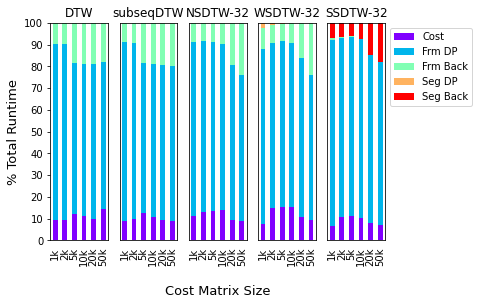

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=5)

# DTW plot
ax = dtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[0])
ax.set_title("DTW")
ax.set_ylabel("% Total Runtime", size=13),
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# Subsequence DTW plot
ax = subsequence_dtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[1])
ax.set_title("subseqDTW")
#ax.set_xlabel("\nCost Matrix Size", size=13),
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# NSDTW plot
ax = nsdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[2])
ax.set_title("NSDTW-32")
ax.set_xlabel("\nCost Matrix Size", size=13),
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# WSDTW plot
ax = wsdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[3])
ax.set_title("WSDTW-32")
#ax.set_xlabel("\nCost Matrix Size", size=13),
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)
ax.get_legend().remove()

# SSDTW plot
ax = ssdtw_df.plot(kind="bar", stacked=True, colormap="rainbow", ax=axes[4])
ax.set_title("SSDTW-32")
ax.set_ylim(0, 100)
ax.set_yticks([])
ax.xaxis.set_ticks_position('none') 
ax.set_xticklabels(labels=['1k','2k','5k','10k','20k','50k'], rotation=90, minor=False)

ax.legend(bbox_to_anchor=(1, 1))

plt.show()
#plt.savefig('runtime.png', bbox_inches = 'tight')

### Data Stats for paper

Collecting some stats on the audio data

In [ ]:
root_dir = 'Chopin_Mazurkas/wav_22050_mono'

In [ ]:
def printAudioStats(indir):
    durs = []
    for infile in glob.glob(f'{indir}/*.wav'):
        y, sr = lb.load(infile)
        durs.append(len(y)/sr)
    durs = np.array(durs)
    
    print(os.path.basename(indir))
    print('---------')
    print(f'Min: {np.min(durs)} s')
    print(f'Max: {np.max(durs)} s')
    print(f'Mean: {np.mean(durs)} s')
    print(f'Std: {np.std(durs)} s')

In [ ]:
for indir in glob.glob(f'{root_dir}/*'):
    printAudioStats(indir)